In [ ]:
pip install pandas numpy matplotlib tensorflow scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math


In [8]:
import pandas as pd
df = pd.read_csv("/content/time_series_data.txt", sep="\t")
print(df.columns.tolist())
print(df.head())


['Date', '        Open', 'High', 'Low', 'Close ', 'Adj Close Volume']
                Date          Open    High     Low  Close  Adj Close Volume
Nov 28, 2025  277.26        279.00  275.99  278.85  278.85       20,135,600
Nov 26, 2025  276.96        279.53  276.63  277.55  277.55       33,431,400
Nov 25, 2025  275.27        280.38  275.25  276.97  276.97       46,914,200
Nov 24, 2025  270.90        277.00  270.90  275.92  275.92       65,585,800
Nov 21, 2025  265.95        273.33  265.67  271.49  271.49       59,030,800


Cleaning the dataset

In [27]:
import pandas as pd
with open("/content/time_series_data.txt", "r") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:5]):
    print(i, "→", line)

df = pd.read_csv("/content/time_series_data.txt", sep="\t", skiprows=1)

df.columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df["Volume"] = df["Volume"].str.replace(",", "").astype(float)

df = df[df["Close"].notnull()]

df.to_csv("stock_prices.csv", index=False)

print(df.head())


0 → Date	        Open	High	Low	Close 	Adj Close Volume

1 → Nov 28, 2025	277.26	279.00	275.99	278.85	278.85	20,135,600

2 → Nov 26, 2025	276.96	279.53	276.63	277.55	277.55	33,431,400

3 → Nov 25, 2025	275.27	280.38	275.25	276.97	276.97	46,914,200

4 → Nov 24, 2025	270.90	277.00	270.90	275.92	275.92	65,585,800

           Date    Open    High     Low   Close  Adj Close      Volume
0  Nov 26, 2025  276.96  279.53  276.63  277.55     277.55  33431400.0
1  Nov 25, 2025  275.27  280.38  275.25  276.97     276.97  46914200.0
2  Nov 24, 2025  270.90  277.00  270.90  275.92     275.92  65585800.0
3  Nov 21, 2025  265.95  273.33  265.67  271.49     271.49  59030800.0
4  Nov 20, 2025  270.83  275.43  265.92  266.25     266.25  45823600.0


In [28]:
from google.colab import files
files.download("stock_prices.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Creating sliding window sequence

In [13]:
series = df["Close"].values.reshape(-1, 1)
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)
X, y = create_sequences(series, window=30)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (2483, 30, 1) y shape: (2483, 1)


Spliting into train test

In [14]:
split = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 1986 Test size: 497


Normalizing

In [16]:
df = pd.read_csv("stock_prices.csv")

close_series = df["Close"].values.reshape(-1,1)

train_size = int(len(close_series)*0.8)
scaler = MinMaxScaler()
scaler.fit(close_series[:train_size])

scaled_series = scaler.transform(close_series)

print("Scaler fixed and ready!")
print("First scaled Close value:", scaled_series[0])


Scaler fixed and ready!
First scaled Close value: [1.]


In [20]:
import numpy as np

series = scaled_series  # scaled close prices
window = 30

X, y = [], []
for i in range(len(series) - window):
    X.append(series[i:i+window])
    y.append(series[i+window])

X = np.array(X)
y = np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], window, 1)
X_test  = X_test.reshape(X_test.shape[0], window, 1)




In [19]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1986, 30, 1)
y_train shape: (1986, 1)
X_test shape: (497, 30, 1)
y_test shape: (497, 1)


In [21]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(30, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Training done!")


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0568 - val_loss: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0023 - val_loss: 1.6325e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 5.5474e-05
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 3.6630e-05
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 3.4826e-05
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 3.9501e-05
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 1.2411e-05
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 2.2149e-05
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 1.1401e-05
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 1.0843e-05
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0014 - val_loss: 1.0845e-05
Epoch 12/20
63/63 ━━━━━

In [23]:
pred = model.predict(X_test)

pred = scaler.inverse_transform(pred)
actual = scaler.inverse_transform(y_test.reshape(-1,1))

print("Sample predictions:", pred[:5].flatten())
print("Sample actuals:", actual[:5].flatten())


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample predictions: [42.248856 42.2044   42.147724 42.02858  41.94742 ]
Sample actuals: [42.54 42.78 42.27 42.83 43.49]


In [24]:
mae = mean_absolute_error(actual, pred)
rmse = math.sqrt(mean_squared_error(actual, pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.6383098434970172
RMSE: 0.830522207802852


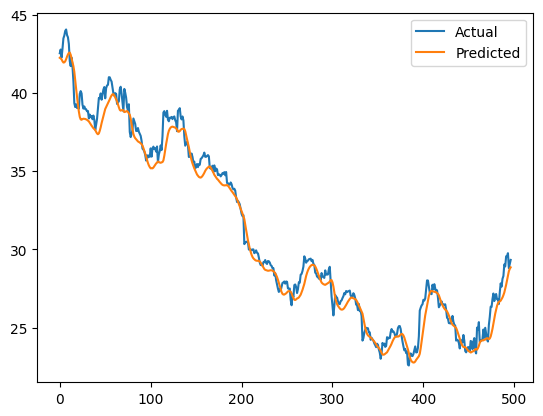

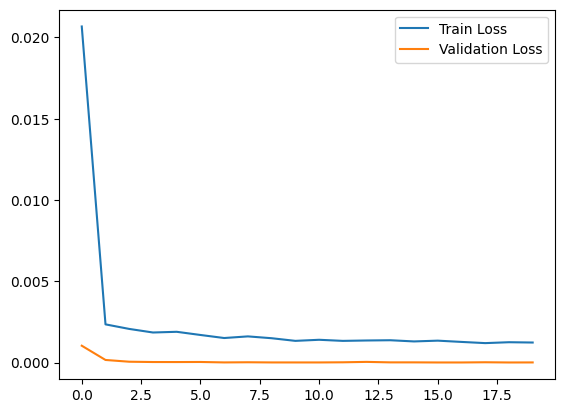

In [25]:
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [26]:
print("Test period covers last 20% of data (hold-out), no shuffle applied to maintain time order.")


Test period covers last 20% of data (hold-out), no shuffle applied to maintain time order.
